In [117]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import layers
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Input
from keras.optimizers import Adam, Adamax
from keras.metrics import categorical_crossentropy
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML
from sklearn.metrics import accuracy_score
from keras.applications import VGG16

from skimage.io import imread
from skimage.color import rgb2gray
from keras import layers, models

from skimage import img_as_ubyte


import cv2
import numpy as np
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Flatten, Dropout

from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf






In [118]:
sdir = r'E:\TRAINING SKRIPSI\Coba'
target_width = 150
target_height = 150

# Definisi fungsi untuk memuat dan memproses citra dengan masking
def load_and_preprocess_image(image_path, mask_path):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Melakukan masking dengan mengalikan citra dan citra mask
    masked_image = cv2.bitwise_and(image, image, mask=mask)

    # Melakukan preprocessing tambahan (misalnya, pengubahan ukuran dan normalisasi)
    masked_image = cv2.resize(masked_image, (target_width, target_height))
    masked_image = masked_image / 255.0  # Normalisasi ke rentang [0, 1]

    return masked_image

filepaths = []
labels = []
dominant_color = []
classlist = os.listdir(sdir)
for klass in classlist:
    classpath = os.path.join(sdir, klass)
    if os.path.isdir(classpath):
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(klass)

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)
print(df.head())
print(df['labels'].value_counts())
train_split = 0.8
test_split = 0.1
dummy_split = test_split / (1 - train_split)
train_df, dummy_df = train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df = train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))


                                           filepaths        labels
0  E:\TRAINING SKRIPSI\Coba\Belum Matang\Belum Ma...  Belum Matang
1  E:\TRAINING SKRIPSI\Coba\Belum Matang\Belum Ma...  Belum Matang
2  E:\TRAINING SKRIPSI\Coba\Belum Matang\Belum Ma...  Belum Matang
3  E:\TRAINING SKRIPSI\Coba\Belum Matang\Belum Ma...  Belum Matang
4  E:\TRAINING SKRIPSI\Coba\Belum Matang\Belum Ma...  Belum Matang
labels
Matang             300
Setengah Matang    156
Belum Matang       142
Name: count, dtype: int64
train_df length:  478   test_df length:  60   valid_df length:  60


In [119]:
height = 150
width = 150
channels = 3
batch_size = 32

img_shape = (height, width, channels)
img_size = (height, width)
length = len(test_df)
test_batch_size = sorted([int(length / n) for n in range(1, length + 1) if length % n == 0 and length / n <= 80], reverse=True)[0]
test_steps = int(length / test_batch_size)
print('test batch size: ', test_batch_size, '  test steps: ', test_steps)

gen = ImageDataGenerator(rescale=1.0 / 255)


test batch size:  60   test steps:  1


In [120]:
# Load and preprocess images with masking
dataset_images = []
dataset_labels = []

image_extensions = ['jpg', 'jpeg', 'png']

dataset_directory = r'E:\TRAINING SKRIPSI\Coba'  # Adjust this to your dataset directory
label_names = os.listdir(dataset_directory)

for label in label_names:
    label_directory = os.path.join(dataset_directory, label)
    for ext in image_extensions:
        image_files = glob.glob(os.path.join(label_directory, f'*.{ext}'))
        for image_path in image_files:
            # Assume there's a corresponding mask with a similar name
            mask_path = os.path.join(label_directory, f'mask_{os.path.basename(image_path)}')

            if os.path.exists(mask_path):
                processed_image = load_and_preprocess_image(image_path, mask_path)
                dataset_images.append(processed_image)
                dataset_labels.append(label)



In [121]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  478   test_df length:  60   valid_df length:  60


In [122]:
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
      rescale=1./255,
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)


test batch size:  60   test steps:  1
Found 478 validated image filenames belonging to 3 classes.
Found 60 validated image filenames belonging to 3 classes.
Found 60 validated image filenames belonging to 3 classes.
['Belum Matang', 'Matang', 'Setengah Matang']


In [123]:
# Create and compile the model
model = Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(target_width, target_height, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(len(label_names), activation='softmax'))

# Tentukan learning rate sesuai kebutuhan Anda, contoh: 0.0001
learning_rate = 0.0001

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Tampilkan ringkasan model
model.summary()


c:\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_96 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,838,787 (18.46 MB)

 Trainable params: 4,838,787 (18.46 MB)

 Non-trainable params: 0 (0.00 B)

In [124]:
def build_vgg16(input_shape=(150, 150, 3), num_classes=3):
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully connected layers with dropout
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))  # Menambahkan dropout dengan tingkat 0.5 (sangat umum)
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))  # Menambahkan dropout di sini juga
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Test the model
input_shape = (150, 150, 3)
num_classes = 3
vgg16_model = build_vgg16(input_shape, num_classes)
vgg16_model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_99 (Conv2D)              │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 4096)           │    33,558,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 3)              │        12,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,066,819 (248.21 MB)

 Trainable params: 65,066,819 (248.21 MB)

 Non-trainable params: 0 (0.00 B)

In [128]:

# Define the callbacks
checkpoint = ModelCheckpoint('TESLAH40.keras', save_best_only=True)

In [129]:

# Train the model
history = model.fit(train_gen, epochs=10, validation_data=valid_gen, callbacks=[checkpoint])


Epoch 1/10


c:\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.4667 - loss: 1.0731 - val_accuracy: 0.5167 - val_loss: 1.0268
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5067 - loss: 0.9999 - val_accuracy: 0.5167 - val_loss: 0.8964
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5287 - loss: 0.8886 - val_accuracy: 0.6167 - val_loss: 0.7693
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6589 - loss: 0.7587 - val_accuracy: 0.7167 - val_loss: 0.6291
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7857 - loss: 0.5717 - val_accuracy: 0.7000 - val_loss: 0.4922
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7972 - loss: 0.4907 - val_accuracy: 0.8167 - val_loss: 0.4453
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8982 - loss: 0.3683 - val_accuracy: 0.9167 - val_loss: 0.2915
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8855 - loss: 0.3119 - val_accuracy: 0.9000 - val_loss: 0.2975
Epo

In [ ]:
# Print the test loss and accuracy
val_loss, val_acc = model.evaluate(test_gen)
print('Validation Loss: {:.2f}%'.format(val_loss * 100))
print('Validation Accuracy: {:.2f}%'.format(val_acc * 100))

1/1 [==============================] - 3s 3s/step - loss: 0.3992 - accuracy: 0.9000
Validation Loss: 39.92%
Validation Accuracy: 90.00%


In [ ]:
# Print the test loss and accuracy
val_loss, val_acc = model.evaluate(valid_gen)
print('Validation Loss: {:.2f}%'.format(val_loss * 100))
print('Validation Accuracy: {:.2f}%'.format(val_acc * 100))

2/2 [==============================] - 3s 2s/step - loss: 0.0731 - accuracy: 0.9833
Validation Loss: 7.31%
Validation Accuracy: 98.33%


In [ ]:
# Function to print text in colored foreground and background
def color_text(text, foreground_color='black', background_color='white'):
    return f'\033[38;5;{foreground_color};48;5;{background_color}m{text}\033[0m'


In [ ]:
# Define a function to print information about misclassifications
def print_info(generator, preds, print_code):
    class_dict = generator.class_indices
    labels = generator.labels
    file_names = generator.filenames
    error_list = []
    true_class = []
    pred_class = []
    prob_list = []
    new_dict = {}
    error_indices = []
    y_pred = []
    for key, value in class_dict.items():
        new_dict[value] = key  # dictionary {integer of class number: string of class name}
    # store new_dict as a text file in the save_dir
    classes = list(new_dict.values())  # list of string of class names
    dict_as_text = str(new_dict)
    errors = 0
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = labels[i]  # labels are integer values
        if pred_index != true_index:  # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors = errors + 1
        y_pred.append(pred_index)
    if print_code != 0:
        if errors > 0:
            if print_code > errors:
                r = errors
            else:
                r = print_code
            msg = '{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class', 'True Class', 'Probability')
            print(msg)
            for i in range(r):
                split1 = os.path.split(error_list[i])
                split2 = os.path.split(split1[0])
                fname = split2[1] + '/' + split1[1]
                msg = '{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i], true_class[i], ' ',
                                                                         prob_list[i])
                print(msg)
        else:
            msg = 'With accuracy of 100 % there are no errors to print'
            print(msg)
    if errors > 0:
        plot_bar = []
        plot_class = []
        for key, value in new_dict.items():
            count = error_indices.count(key)
            if count != 0:
                plot_bar.append(count)  # list containing how many times a class c had an error
                plot_class.append(value)  # stores the class
        fig = plt.figure()
        fig.set_figheight(len(plot_class) / 3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c = plot_class[i]
            x = plot_bar[i]
            plt.barh(c, x)
            plt.title('Errors by Class on Validation Set')
    y_true = np.array(labels)
    y_pred = np.array(y_pred)
    if len(classes) <= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        length = len(classes)
        if length < 8:
            fig_width = 8
            fig_height = 8
        else:
            fig_width = int(length * .5)
            fig_height = int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length) + .5, classes, rotation=90)
        plt.yticks(np.arange(length) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)


15/15 [==============================] - 54s 4s/step


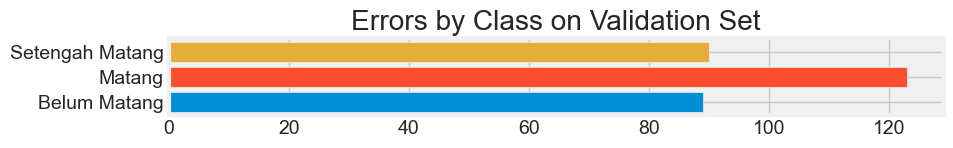

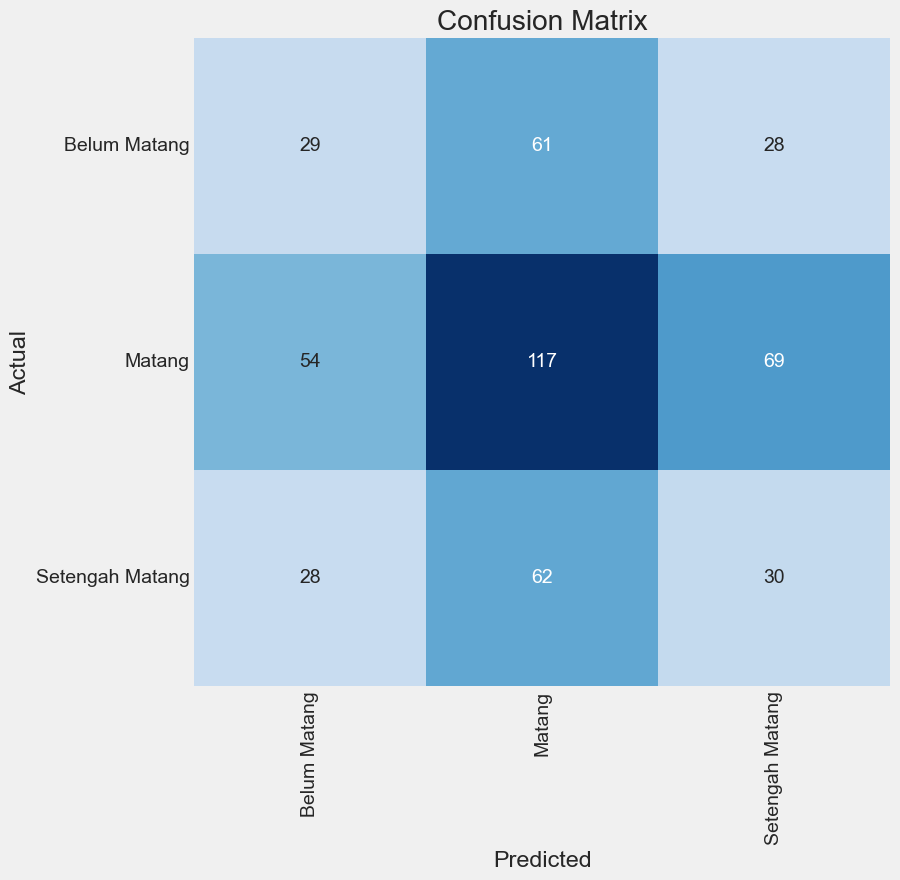

Classification Report:
----------------------
                  precision    recall  f1-score   support

   Belum Matang       0.26      0.25      0.25       118
         Matang       0.49      0.49      0.49       240
Setengah Matang       0.24      0.25      0.24       120

       accuracy                           0.37       478
      macro avg       0.33      0.33      0.33       478
   weighted avg       0.37      0.37      0.37       478



In [ ]:
print_code = 0
preds = model.predict(train_gen)  # Gunakan val_generator untuk dataset validasi
print_info(train_gen, preds, print_code)

In [ ]:
# Plot the training and validation data
def plot_metrics(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()



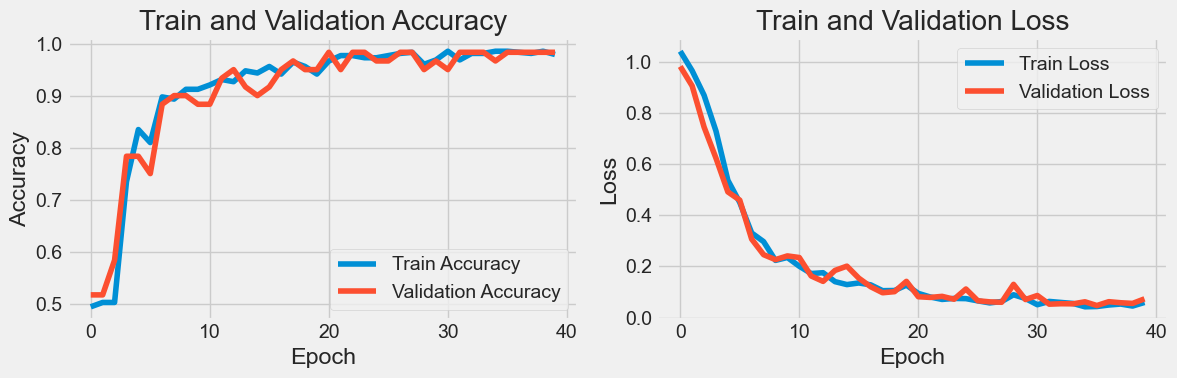

In [ ]:
plot_metrics(history)